In [93]:
import sys, os, time

import igl
import open3d as o3d
from meshplot import plot

import scipy as sp
import numpy as np
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt

%matplotlib inline

## Part 1

In [2]:
# utility function
def show_pointcloud(points):
    pts_o3d = o3d.geometry.PointCloud()
    pts_o3d.points = o3d.utility.Vector3dVector(points)
    o3d.visualization.draw_geometries([pts_o3d])

def evaluate_align(source_ply, target_ply, threshold=0.001):
    source_ptc = o3d.geometry.PointCloud()
    target_ptc = o3d.geometry.PointCloud()
    source_ptc.points = o3d.utility.Vector3dVector(np.asarray(source_ply.vertices))
    target_ptc.points = o3d.utility.Vector3dVector(np.asarray(target_ply.vertices))
    evaluation = o3d.pipelines.registration.evaluate_registration(source_ptc, target_ptc, threshold)
    return evaluation

### 1. Select a subset of points $p_i$

In [3]:
def uniform_sample(ply, n=1000):
    pcd = ply.sample_points_uniformly(number_of_points=n)
    p = pcd.points
    return np.asarray(p)

### 2. Match each $p_i$ to closest point $q_i$ on other scan

In [4]:
def match_points(sampled_pts, mesh_pts):
    n_pts, dim = sampled_pts.shape
    tree = KDTree(mesh_pts, leaf_size=2)
    dist, idx = tree.query(sampled_pts, k=1)
    return dist.reshape((n_pts,)), mesh_pts[idx].reshape((n_pts, dim))

### 3. Reject "bad" pairs $(p_i, q_i)$

In [5]:
def reject_pairs(p, q, dist):
    med = np.median(dist)
    idx = np.where(dist < 2. * med)
    return p[idx], q[idx]

### 4. Compute rotation $R$ and translation $t$

In [6]:
def solve_Rt(p, q):
    p_avg = np.mean(p, axis=0)
    q_avg = np.mean(q, axis=0)
    P = (p - p_avg).T
    Q = (q - q_avg).T
    u, s, vh = np.linalg.svd(Q @ P.T, full_matrices=True)
    R = vh.T @ np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., np.linalg.det(vh.T @ u.T)]
    ]) @ u.T
    t = p_avg - R @ q_avg
    return R, t

### 5. Iterate after scan alignment: $q_i \larr Rq_i + t$

In [7]:
def paint_overlap(ply1, ply2, radius=0.001):
    ply1_non_overlap_color = np.array([255, 127, 80]) / 255.
    overlap_color = np.array([138, 43, 226]) / 255.
    ply2_non_overlap_color = np.array([3, 168, 158]) / 255.
    
    points1 = np.asarray(ply1.vertices)
    points2 = np.asarray(ply2.vertices)
    colors1 = np.zeros((points1.shape[0], 3))
    colors2 = np.zeros((points2.shape[0], 3))

    tree1 = KDTree(points1, leaf_size=10) 
    tree2 = KDTree(points2, leaf_size=10) 

    has_neighbours1 = tree2.query_radius(points1, r=radius, count_only=True)
    colors1[has_neighbours1==0] = ply1_non_overlap_color
    colors1[has_neighbours1!=0] = overlap_color

    has_neighbours2 = tree1.query_radius(points2, r=radius, count_only=True)
    colors2[has_neighbours2==0] = ply2_non_overlap_color
    colors2[has_neighbours2!=0] = overlap_color

    ply1.vertex_colors=o3d.utility.Vector3dVector(colors1)
    ply2.vertex_colors=o3d.utility.Vector3dVector(colors2)

    return ply1, ply2

In [61]:
def icp(mesh1_fp, mesh2_fp, tl=1e-3, init_transform=None, max_it=300, sample_number=1000):
    # mesh2 to mesh1

    ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
    ply2 = o3d.io.read_triangle_mesh(mesh2_fp)

    if init_transform is not None:
        ply2 = ply2.transform(init_transform)

    # ply1 = ply1.compute_vertex_normals()
    # ply2 = ply2.compute_vertex_normals()

    E = np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
    ])
    
    cnt_it = 0
    while cnt_it < max_it:
    
        points1 = np.asarray(ply1.vertices)
        sampled_points2 = uniform_sample(ply2, sample_number)
        
        dist, corr_points1 = match_points(sampled_points2, points1)
        p, q = reject_pairs(corr_points1, sampled_points2, dist)
        R, t = solve_Rt(p, q)

        if np.linalg.norm(E - R) < tl:
            ply1, ply2 = paint_overlap(ply1, ply2)
            print("Possible to be aligned after %d iteration(s)." % cnt_it)
            return ply1, ply2

        cnt_it += 1
        ply2 = ply2.rotate(R)
        ply2 = ply2.translate(t)

    print("ICP stopped after max iteration number %d." % max_it)
    return ply1, ply2


In [58]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun045_v2.ply')
ply1, ply2 = icp(mesh1_fp, mesh2_fp)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun045_v2_reg_paint.ply'), ply2)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint045.ply'), ply1)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)

Possible to be aligned after 55 iteration(s).
RegistrationResult with fitness=9.153553e-01, inlier_rmse=3.821589e-04, and correspondence_set size of 36703
Access transformation to get result.


In [11]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun270_v2.ply')
ply1, ply2 = icp(mesh1_fp, mesh2_fp)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint270.ply'), ply1)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun270_v2_reg_paint.ply'), ply2)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)

RegistrationResult with fitness=9.441343e-02, inlier_rmse=6.404660e-04, and correspondence_set size of 2993
Access transformation to get result.


## Part 2

In [37]:
def rotate_and_save(mesh_fp, angle, mesh_save_fp):
    # about z-axis
    ply = o3d.io.read_triangle_mesh(mesh_fp)
    R = np.array([
        [np.cos(angle), -np.sin(angle), 0.],
        [np.sin(angle),  np.cos(angle), 0.],
        [           0.,             0., 1.]
    ])
    ply = ply.rotate(R)
    o3d.io.write_triangle_mesh(mesh_save_fp, ply)

In [96]:
rotate_angle_about_z = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]) / 12 * np.pi
rotate_angle_degree = np.zeros(rotate_angle_about_z.shape)
fitness_res_rotate = np.zeros(rotate_angle_about_z.shape)
mesh_dir_fp = 'bunny_v2'
mesh_origin_fn = 'bun000_v2.ply'
for i, angle in enumerate(rotate_angle_about_z):
    angle_to_degree = int(round(180 * angle / np.pi))
    mesh_after_rotation_fn = 'bun000_v2_rotate_z_%d.ply' % angle_to_degree
    mesh1_fp = os.path.join(mesh_dir_fp, mesh_origin_fn)
    mesh2_fp = os.path.join(mesh_dir_fp, mesh_after_rotation_fn)
    rotate_and_save(mesh1_fp, angle, mesh2_fp)
    print('Rotate angle: %d' % angle_to_degree)
    ply1, ply2 = icp(mesh1_fp, mesh2_fp)
    evaluation = evaluate_align(ply2, ply1)
    rotate_angle_degree[i] = angle_to_degree
    fitness_res_rotate[i] = evaluation.fitness
    # print(evaluation)

Rotate angle: 15
Possible to be aligned after 80 iteration(s).
Rotate angle: 30
Possible to be aligned after 128 iteration(s).
Rotate angle: 45
Possible to be aligned after 156 iteration(s).
Rotate angle: 60
Possible to be aligned after 243 iteration(s).
Rotate angle: 75
Possible to be aligned after 283 iteration(s).
Rotate angle: 90
Possible to be aligned after 115 iteration(s).
Rotate angle: 105
Possible to be aligned after 37 iteration(s).
Rotate angle: 120
Possible to be aligned after 13 iteration(s).
Rotate angle: 135
Possible to be aligned after 29 iteration(s).
Rotate angle: 150
Possible to be aligned after 65 iteration(s).
Rotate angle: 165
Possible to be aligned after 38 iteration(s).
Rotate angle: 180
Possible to be aligned after 55 iteration(s).


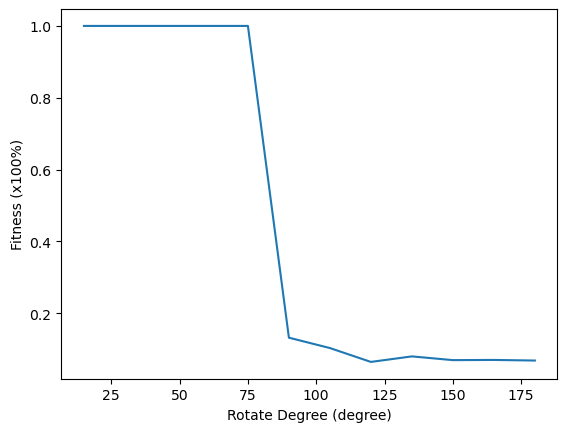

In [97]:
plt.plot(rotate_angle_degree, fitness_res_rotate)
plt.xlabel('Rotate Degree (degree)')
plt.ylabel('Fitness (x100%)')
plt.show()

## Part 3

In [40]:
def perturb_and_save(mesh_fp, sigma, mesh_save_fp):
    # about z-axis
    ply = o3d.io.read_triangle_mesh(mesh_fp)
    points = np.asarray(ply.vertices)
    noises = np.random.normal(0, sigma, points.shape)
    ply.vertices = o3d.utility.Vector3dVector(points + noises)
    o3d.io.write_triangle_mesh(mesh_save_fp, ply)

In [98]:
noise_sigmas = np.array([1e-5, 
                         1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4,
                         1e-3, 2e-3, 3e-3, 4e-3, 5e-3, 
                         1e-2, 5e-2, 1e-1])
fitness_res_perturb = np.zeros(noise_sigmas.shape)
mesh_dir_fp = 'bunny_v2'
mesh_origin_fn = 'bun000_v2.ply'
for i, sigma in enumerate(noise_sigmas):
    mesh_after_perturb = 'bun000_v2_perturb_%.6f.ply' % sigma
    mesh1_fp = os.path.join(mesh_dir_fp, mesh_origin_fn)
    mesh2_fp = os.path.join(mesh_dir_fp, mesh_after_perturb)
    perturb_and_save(mesh1_fp, sigma, mesh2_fp)
    print('Sigma: %.6f' % sigma)
    ply1, ply2 = icp(mesh1_fp, mesh2_fp)
    evaluation = evaluate_align(ply2, ply1)
    fitness_res_perturb[i] = evaluation.fitness
    # print(evaluation)

Sigma: 0.000010
Possible to be aligned after 0 iteration(s).
Sigma: 0.000100
Possible to be aligned after 0 iteration(s).
Sigma: 0.000200
Possible to be aligned after 0 iteration(s).
Sigma: 0.000300
Possible to be aligned after 0 iteration(s).
Sigma: 0.000400
Possible to be aligned after 0 iteration(s).
Sigma: 0.000500
Possible to be aligned after 0 iteration(s).
Sigma: 0.000600
Possible to be aligned after 0 iteration(s).
Sigma: 0.000700
Possible to be aligned after 0 iteration(s).
Sigma: 0.000800
Possible to be aligned after 0 iteration(s).
Sigma: 0.000900
Possible to be aligned after 1 iteration(s).
Sigma: 0.001000
Possible to be aligned after 1 iteration(s).
Sigma: 0.002000
Possible to be aligned after 1 iteration(s).
Sigma: 0.003000
Possible to be aligned after 0 iteration(s).
Sigma: 0.004000
Possible to be aligned after 8 iteration(s).
Sigma: 0.005000
Possible to be aligned after 21 iteration(s).
Sigma: 0.010000
ICP stopped after max iteration number 300.
Sigma: 0.050000
ICP stop

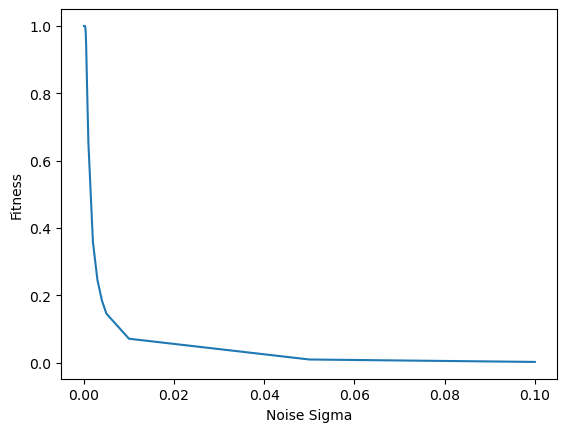

In [99]:
plt.plot(noise_sigmas, fitness_res_perturb)
plt.xlabel('Noise Sigma')
plt.ylabel('Fitness (x100%)')
plt.show()

## Part 4

In [115]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun045_v2.ply')

ply2 = o3d.io.read_triangle_mesh(mesh2_fp)
points2 = np.asarray(ply2.vertices)
pts2_number = points2.shape[0]
sample_numbers = (np.array([1e-4, 2e-4, 4e-4, 6e-4, 8e-4,
                            1e-3, 2e-3, 4e-3, 6e-3, 8e-3,
                            1e-2, 2e-2, 4e-2, 6e-2, 8e-2,
                            1e-1, 3e-1, 5e-1, 1]) * pts2_number).astype(np.int64)
log_sample_rates = np.log10(sample_numbers / pts2_number)
fitness_res_sample = np.zeros(sample_numbers.shape)
time_costs = np.zeros(sample_numbers.shape)
for i, sample_number in enumerate(sample_numbers):
    print("Sample number: %d." % sample_number)
    start = time.time()
    ply1, ply2 = icp(mesh1_fp, mesh2_fp, 1e-3, None, 300, sample_number)
    time_cost = time.time() - start
    evaluation = evaluate_align(ply2, ply1)
    fitness_res_sample[i] = evaluation.fitness
    time_costs[i] = time_cost
    # print(evaluation)

Sample number: 4.
Possible to be aligned after 72 iteration(s).
Sample number: 8.
Possible to be aligned after 45 iteration(s).
Sample number: 16.
Possible to be aligned after 81 iteration(s).
Sample number: 24.
Possible to be aligned after 108 iteration(s).
Sample number: 32.
Possible to be aligned after 74 iteration(s).
Sample number: 40.
Possible to be aligned after 102 iteration(s).
Sample number: 80.
Possible to be aligned after 57 iteration(s).
Sample number: 160.
Possible to be aligned after 63 iteration(s).
Sample number: 240.
Possible to be aligned after 61 iteration(s).
Sample number: 320.
Possible to be aligned after 71 iteration(s).
Sample number: 400.
Possible to be aligned after 65 iteration(s).
Sample number: 801.
Possible to be aligned after 60 iteration(s).
Sample number: 1603.
Possible to be aligned after 61 iteration(s).
Sample number: 2405.
Possible to be aligned after 56 iteration(s).
Sample number: 3207.
Possible to be aligned after 58 iteration(s).
Sample number:

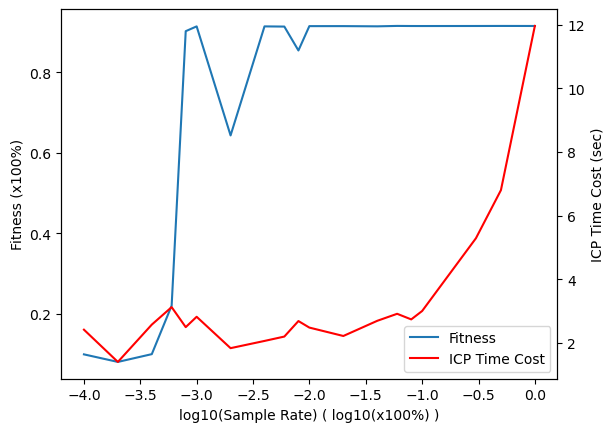

In [116]:
fig = plt.figure()
ax1 = fig.add_subplot()
ln1 = ax1.plot(log_sample_rates, fitness_res_sample, label='Fitness')
ax1.set_xlabel('log10(Sample Rate) ( log10(x100%) )')
ax1.set_ylabel('Fitness (x100%)')

ax2 = ax1.twinx()
ln2 = ax2.plot(log_sample_rates, time_costs, 'r', label='ICP Time Cost')
ax2.set_ylabel('ICP Time Cost (sec)')

lns = ln1 + ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
plt.show()

## Part 5

In [12]:
def convert_pts_to_ptc(pts):
    pts_o3d = o3d.geometry.PointCloud()
    pts_o3d.points = o3d.utility.Vector3dVector(pts)
    return pts_o3d

In [13]:
def preprocess_point_cloud(pcd_down, voxel_size):
    radius_normal = voxel_size * 2
    pcd_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    radius_feature = voxel_size * 5
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(pcd_down, o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_fpfh

In [14]:
def prepare_dataset(voxel_size, mesh1_fp, mesh2_fp):
    ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
    ply2 = o3d.io.read_triangle_mesh(mesh2_fp)
    source_down = convert_pts_to_ptc(uniform_sample(ply2, 10000))
    target_down = convert_pts_to_ptc(uniform_sample(ply1, 10000))

    source_fpfh = preprocess_point_cloud(source_down, voxel_size)
    target_fpfh = preprocess_point_cloud(target_down, voxel_size)
    return source_down, target_down, source_fpfh, target_fpfh

In [15]:
def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh, voxel_size):
    distance_threshold = voxel_size * 0.5
    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

In [16]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun315_v2.ply')
voxel_size = 0.005
source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(voxel_size, mesh1_fp, mesh2_fp)
result = execute_fast_global_registration(source_down, target_down, source_fpfh, target_fpfh, voxel_size)
print(result.transformation)

[[ 7.14326914e-01 -1.59166643e-02 -6.99631131e-01 -7.27325135e-03]
 [ 2.18547847e-02  9.99761063e-01 -4.30798926e-04  1.43345993e-04]
 [ 6.99470820e-01 -1.49825565e-02  7.14504090e-01 -1.30069892e-02]
 [-0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.00000000e+00]]


In [17]:
ply1, ply2 = icp(mesh1_fp, mesh2_fp, 5e-4, result.transformation)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_paint315.ply'), ply1)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun315_v2_reg_paint.ply'), ply2)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)

RegistrationResult with fitness=7.965531e-01, inlier_rmse=4.125364e-04, and correspondence_set size of 28147
Access transformation to get result.


## Part 6

In [18]:
def ptpl_match_points(sampled_pts, mesh_pts, n):
    n_pts, dim = sampled_pts.shape
    tree = KDTree(mesh_pts, leaf_size=2)
    dist, idx = tree.query(sampled_pts, k=1)
    return dist.reshape((n_pts,)), mesh_pts[idx].reshape((n_pts, dim)), n[idx].reshape((n_pts, dim))

In [19]:
def ptpl_reject_pairs(p, q, dist, n):
    med = np.median(dist)
    idx = np.where(dist < 2. * med)
    return p[idx], q[idx], n[idx]

In [69]:
def ptpl_solve_Rt(p, q, n_p):
    a = np.cross(q, n_p)
    A = np.hstack((a, n_p))
    b = np.sum(n_p * p - n_p * q, axis=1)
    
    u, s, vh = np.linalg.svd(A, full_matrices=False)
    Aplus = vh.T @ np.linalg.pinv(np.diag(s)) @ u.T
    # x = (np.linalg.pinv(A.T @ A) @ A.T @ b).reshape((6,))
    alpha, beta, gamma, tx, ty, tz = b @ Aplus.T

    R = np.array([
        [1., -gamma, beta],
        [gamma, 1., -alpha],
        [-beta, alpha, 1.]
    ])
    t = np.array([tx, ty, tz])
    return R, t

In [77]:
def ptpl_icp(mesh1_fp, mesh2_fp, tl=5e-4, max_it=300):
    # mesh2 to mesh1

    ply1 = o3d.io.read_triangle_mesh(mesh1_fp)
    ply2 = o3d.io.read_triangle_mesh(mesh2_fp)

    ply1 = ply1.compute_vertex_normals()
    n_p = np.asarray(ply1.vertex_normals)

    E = np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
    ])
    
    cnt_it = 0
    while cnt_it < max_it:
    
        points1 = np.asarray(ply1.vertices)
        sampled_points2 = uniform_sample(ply2)
        
        dist, corr_points1, n = ptpl_match_points(sampled_points2, points1, n_p)
        p, q, n = ptpl_reject_pairs(corr_points1, sampled_points2, dist, n_p)
        R, t = ptpl_solve_Rt(p, q, n)

        if np.linalg.norm(E - R) < tl:
            ply1, ply2 = paint_overlap(ply1, ply2)
            print("Possible to be aligned after %d iteration(s)." % cnt_it)
            return ply1, ply2

        cnt_it += 1
        ply2 = ply2.rotate(R)
        ply2 = ply2.translate(t)

    print("ICP stopped after max iteration number %d." % max_it)
    return ply1, ply2

In [78]:
mesh1_fp = os.path.join('bunny_v2', 'bun000_v2.ply')
mesh2_fp = os.path.join('bunny_v2', 'bun045_v2.ply')
ply1, ply2 = ptpl_icp(mesh1_fp, mesh2_fp)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun000_v2_ptpl_paint045.ply'), ply1)
o3d.io.write_triangle_mesh(os.path.join('bunny_v2', 'bun045_v2_ptpl_reg_paint.ply'), ply2)
evaluation = evaluate_align(ply2, ply1)
print(evaluation)

Possible to be aligned after 138 iteration(s).
RegistrationResult with fitness=5.171210e-01, inlier_rmse=5.767586e-04, and correspondence_set size of 20735
Access transformation to get result.
